In [4]:
import os
import torchvision.models as models
from src.dataset.MonkeyDataset import label2name

In [6]:
import torch.nn.functional as F
from torch import nn
from torch import optim
import torch

In [21]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(3,3,3,1)
        self.conv2 = nn.Conv2d(3,3,3,1)
        self.fc1 = nn.Linear(2700, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self,x):
        x=self.conv1(x)
        x=F.relu(x)
        x=self.conv2(x)
        x=F.relu(x)
        x=F.max_pool2d(x,2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [8]:
model = models.resnet18(pretrained=True)

In [22]:
model = NeuralNet()

In [23]:
print(model)

NeuralNet(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2700, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [12]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import numpy as np

import torch 
import torchvision

batch_size = 32
learning_rate = 1e-3

transforms = transforms.Compose(
[
    transforms.RandomResizedCrop(64, scale=(1.0, 1.0)),
    transforms.ToTensor()
])

#os.chdir('/Users/andrzej/Personal/MonkeysKaggle')

train_data = datasets.ImageFolder('data/training/training', transform = transforms)
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True,  num_workers=4)

test_data = datasets.ImageFolder('data/validation/validation', transform = transforms)
test_data_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True,  num_workers=4)

    
images, labels = next(iter(train_data_loader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

images-size: torch.Size([32, 3, 64, 64])
out-size: torch.Size([3, 266, 530])


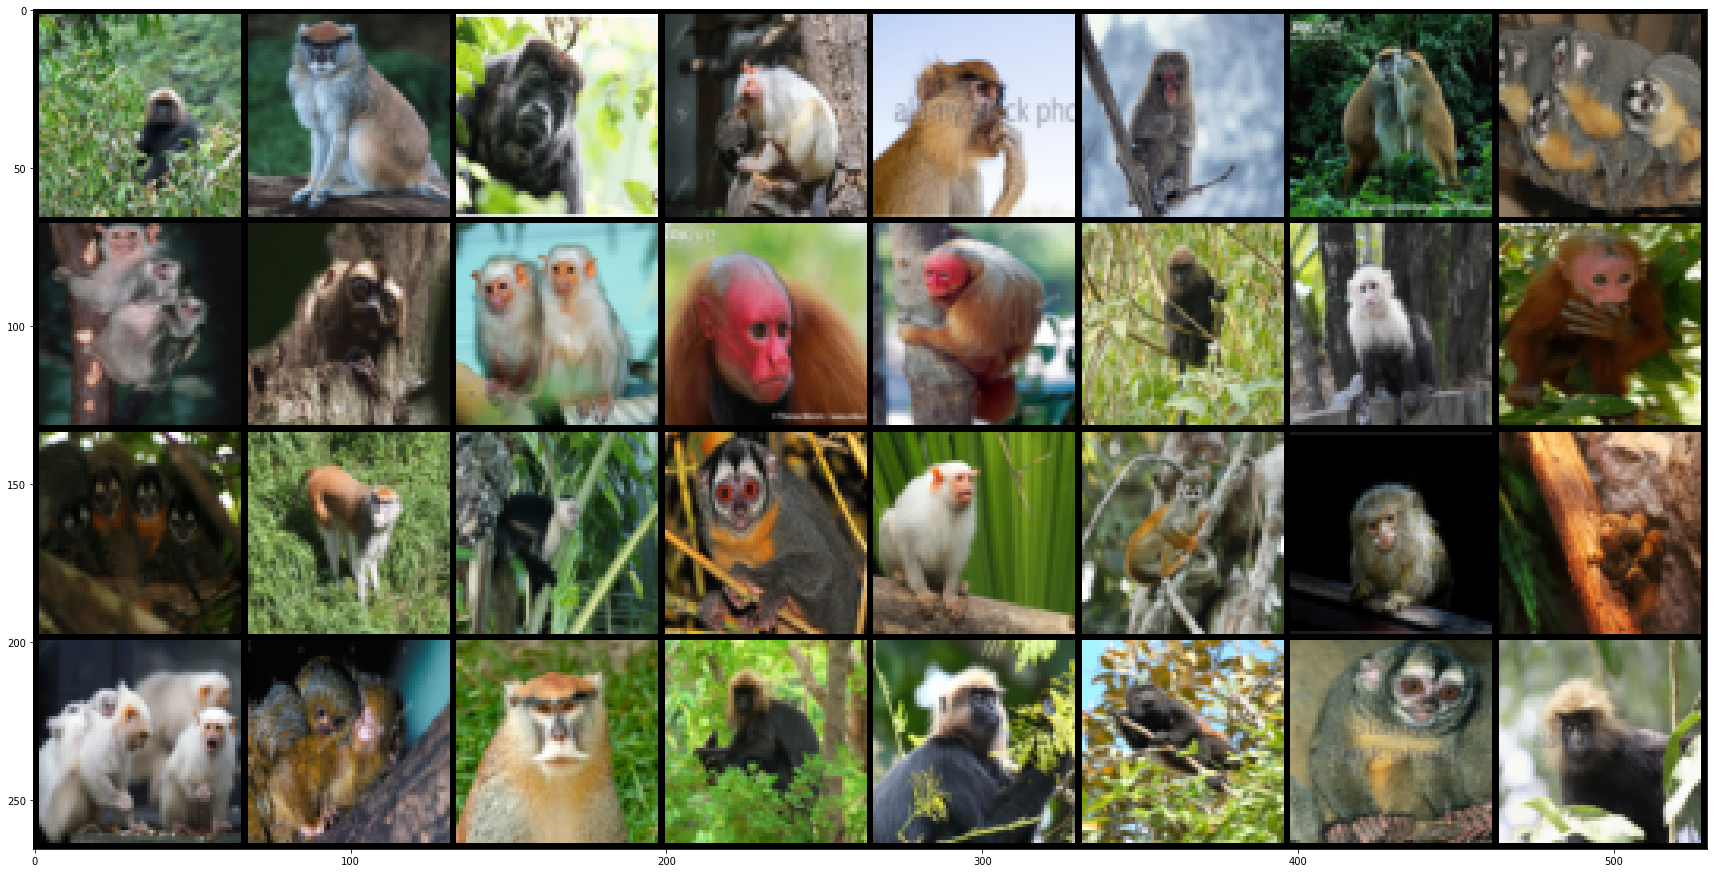

In [13]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=30,30

plt.imshow(out.permute(1, 2, 0))

In [24]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

#num_ftrs = model.fc.in_features
#model.fc = nn.Linear(num_ftrs, 10)
#model

In [1]:
n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_data_loader)

for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_data_loader):
        #data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (test_data_loader):
            #data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
            
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_data_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')


NameError: name 'np' is not defined

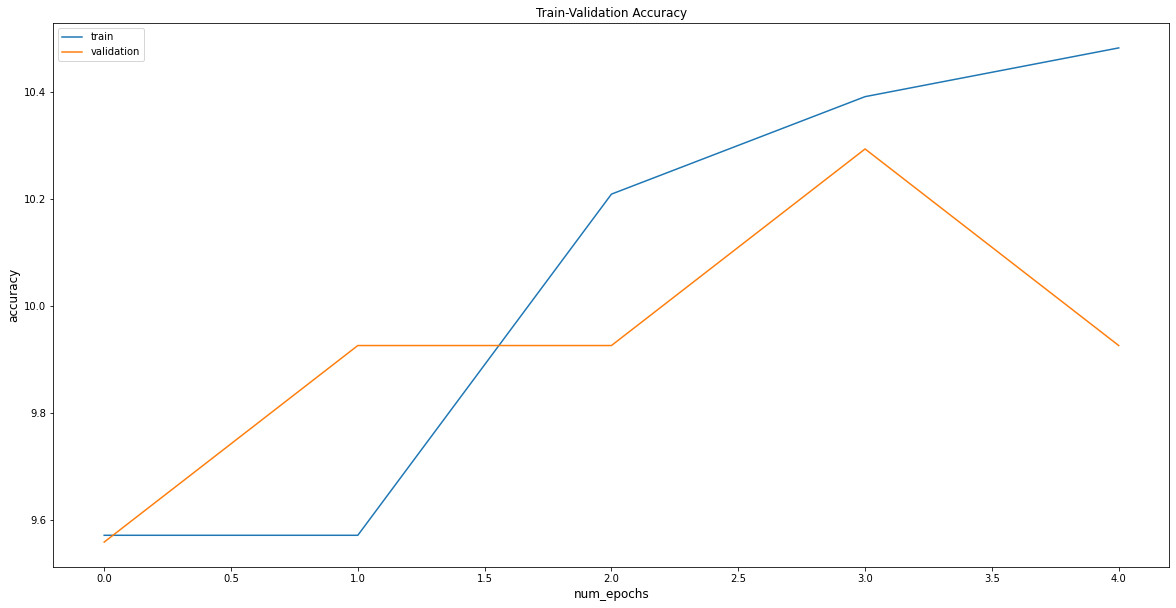

In [26]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')


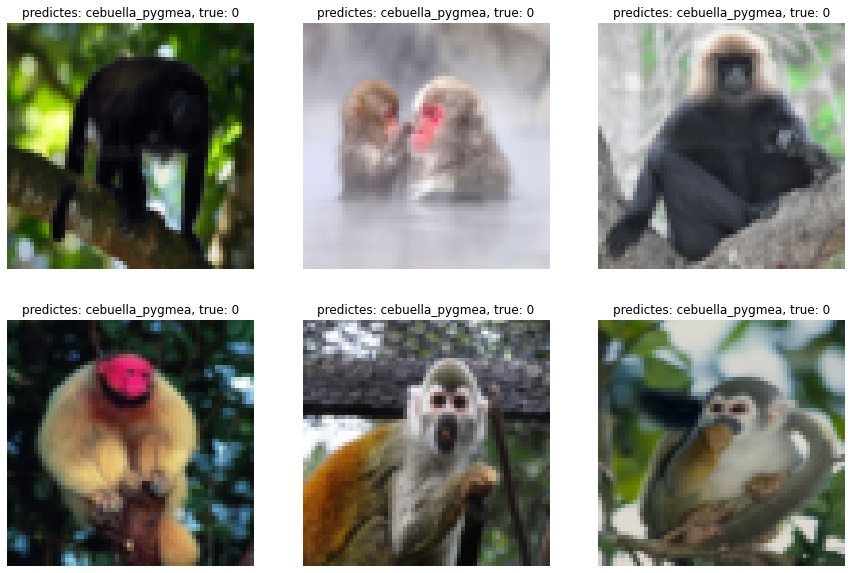

In [32]:
def visualize_model(net, num_images=6, test_dataloader=None, test_dataset=None):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}, true: {}'.format(label2name[test_dataset.classes[preds[j]]], labels[i] ))
            plt.imshow(inputs[j].permute(1, 2, 0))
            
            if images_so_far == num_images:
                return 

visualize_model(model, test_dataloader=test_data_loader, test_dataset=test_data)

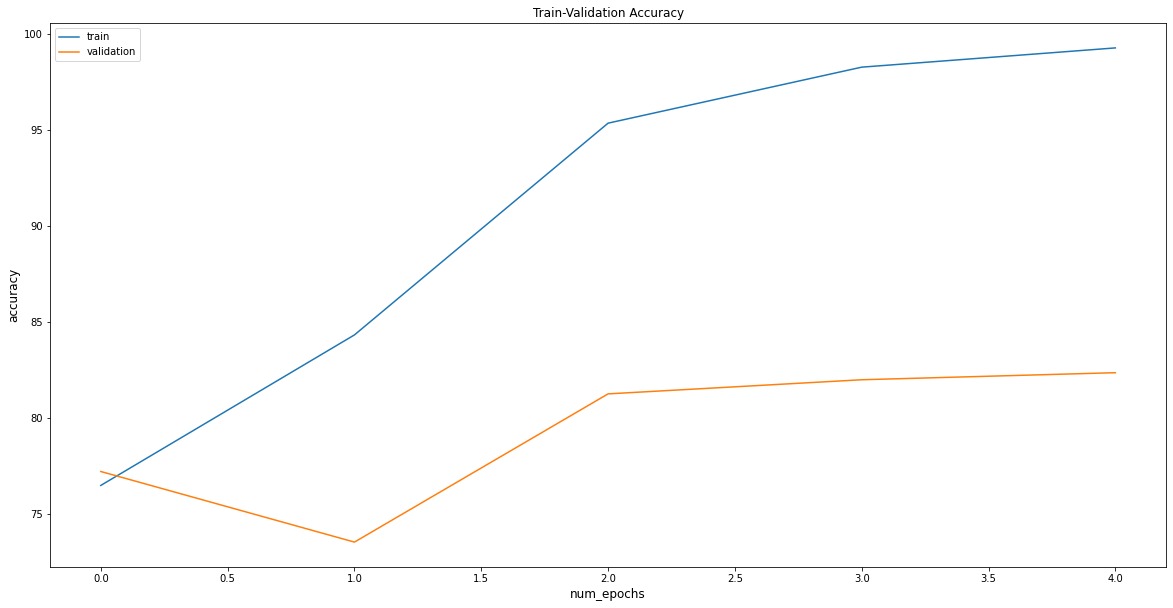

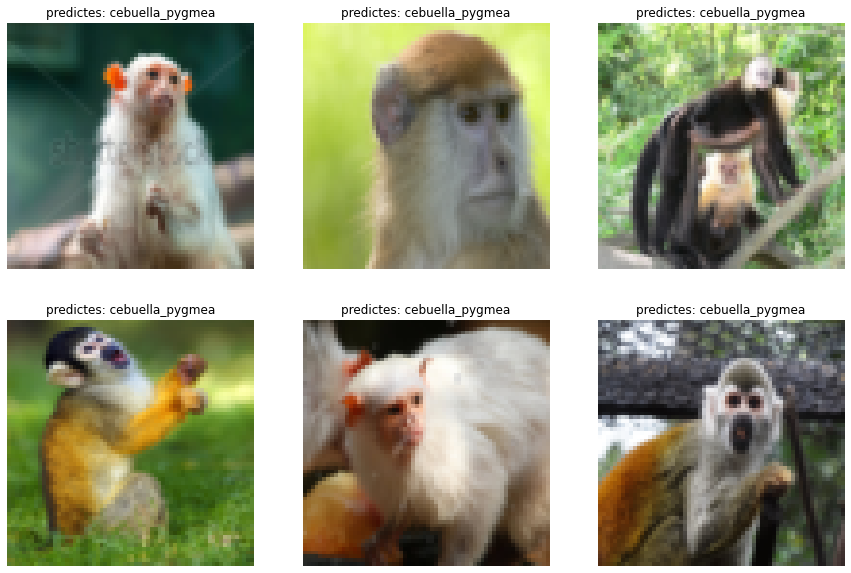

In [28]:
def visualize_model(net, num_images=6, test_dataloader=None, test_dataset=None):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(label2name[test_dataset.classes[preds[j]]]))
            plt.imshow(inputs[j].permute(1, 2, 0))
            
            if images_so_far == num_images:
                return 

visualize_model(model, test_dataloader=test_data_loader, test_dataset=test_data)